# Genetic Algorithm NeuroEvolution
Evolving the weights of a fixed Neural Controller using Genetic Algorithm

In [41]:
import sys
import os
import numpy as np
import random
from deap import base, creator, tools, algorithms
import importlib

# Add the parent directory to the Python path
sys.path.append(os.path.abspath('../'))
import environment 
import neural_controller
import utils
importlib.reload(environment)
importlib.reload(neural_controller)
importlib.reload(utils)

<module 'utils' from '/Users/lorenzoleuzzi/Documents/GitHub/lifelong_evolutionary_swarms/utils.py'>

In [28]:
env = environment.Environment(objective = [(environment.RED, environment.UP)],
                   size = environment.SIMULATION_ARENA_SIZE, 
                   n_agents = 10, 
                   n_blocks = 20,
                   n_neighbors = 3,
                   sensor_range = environment.SIMULATION_SENSOR_RANGE,
                   sensor_angle = 360,
                   max_wheel_velocity=environment.SIMULATION_MAX_WHEEL_VELOCITY,
                   sensitivity = 0.5,
                   initial_setting=environment.HARD_INITIAL_SETTING,
                   seed = 42)
env.reset()
env.print_env()

. . . 0 . . 1 . . 2 . . 3 . . 4 . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . O O . . . . . . . . . . . . . .
. . . . . . . . . . . . O . . . . . . .
. . . . . . . O . . . . . . . . O . . .
. . . . . . . . . . . O . . . . . . . .
. . . O . . . . . . . O . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . O . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . O . . . . . . . . . O . . . O . .
. . . . . . . . O . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .



In [32]:
input_dim = (env.n_types + 2 + 1) * env.n_neighbors + 2 + env.n_types - 2
output_dim = 3
hidden_units = [8, 16]
layer_sizes = [input_dim] + hidden_units + [output_dim]

nn = neural_controller.NeuralController(layer_sizes, hidden_activation="neat_sigmoid", output_activation="neat_sigmoid")
nn.summary()

NeuralController with layer sizes:  [49, 8, 16, 3]
Total weights: 595, not set


In [33]:
def calculate_fitness(individual, n_steps=500, verbose = False):
        
    fitness = 0
    obs, _ = env.reset()
    
    # Set the weights of the network
    nn.set_weights_from_vector(individual)

    for step in range(n_steps):
        
        nn_inputs = env.process_observation(obs)
        nn_outputs = np.array(nn.predict(nn_inputs))
        actions = (2 * nn_outputs - 1) * env.max_wheel_velocity # Scale output sigmoid in range of wheel velocity
            
        obs, reward, done, _, _ = env.step(actions)

        fitness += reward

        if verbose:
            print("\nStep", step)
            # print("Observation: ", obs)
            # print("NN inputs: ", nn_inputs)
            print("Action: ", actions)
            env.print_env()
            print("Reward: ", reward)
        
        if done:
            fitness += (n_steps - step) / 2
            break
    
    return [float(fitness)]

def selElitistAndTournament(individuals, k, frac_elitist = 0.1, tournsize = 3):
    return tools.selBest(individuals, int(k*frac_elitist)) + tools.selTournament(individuals, int(k*(1-frac_elitist)), tournsize=tournsize)

In [43]:
pop_size = 150
n_generations = 200
num_elite = int(0.05 * pop_size) # 5% of the population will be copied to the next generation (elitism)
num_removed = int(0.1 * pop_size) # 10% of the population will be removed and randomly replaced
tournament_size = int(0.03 * pop_size)
offspring_size = pop_size - num_elite - num_removed

# Set up the fitness and individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximization problem
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("evaluate", calculate_fitness)  # Evaluation function

toolbox.register("attr_float", random.uniform, -1.0, 1.0)  # Attribute generator
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=nn.total_weights)  # Individual generator
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("select", tools.selTournament, tournsize=tournament_size)  # Selection function
# toolbox.register("select", selElitistAndTournament)  # Selection function
toolbox.register("mate", tools.cxTwoPoint)  # Crossover function
# toolbox.register("mate", tools.cxOnePoint)  # Crossover function
# toolbox.register("mate", tools.cxUniform, indpb=0.5)  # 50% chance for each weight
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)  # Mutation function

# Statistics to keep track of the evolution
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("best", np.max)
stats.register("avg", np.mean)
stats.register("median", np.median)
stats.register("std", np.std)
stats.register("worst", np.min)

pop = toolbox.population(n=pop_size)  # Create a population 
hof = tools.HallOfFame(2)  # Hall of fame to store the best individual

In [40]:
mu = 100
lambda_ = 200
pop, log = algorithms.eaMuPlusLambda(pop, toolbox, mu=mu, lambda_=lambda_, cxpb=0.5, mutpb=0.5, ngen=n_generations,
                                    stats=stats, halloffame=hof, verbose=True)

gen	nevals	best  	avg      	median	std    	worst  
0  	0     	1.2397	-0.631573	0     	1.53399	-7.9169
1  	200   	1.2397	0.076037 	0     	0.290922	-1.8884
2  	200   	1.2397	0.107082 	0     	0.201379	0      
3  	200   	1.2397	0.144844 	0.1189	0.219994	0      
4  	200   	1.2397	0.205307 	0.1252	0.288958	0      
5  	200   	1.2397	0.274943 	0.1645	0.283661	0      


KeyboardInterrupt: 

In [29]:
# Run the genetic algorithm
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.8, mutpb=0.8, ngen=n_generations,
                                   stats=stats, halloffame=hof, verbose=True)

gen	nevals	best  	avg     	median	std    	worst
0  	150   	0.7272	-793.526	-859  	458.522	-1403


KeyboardInterrupt: 

In [44]:
pop, log = utils.eaSimpleWithElitism(pop, toolbox, cxpb=0.8, mutpb=0.8, ngen=n_generations,
                                   stats=stats, halloffame=hof, verbose=True)                                

gen	nevals	best  	avg      	median	std    	worst  
0  	150   	1.0057	-0.536826	0     	1.53924	-9.6378
1  	145   	1.1872	-0.376622	0     	1.30821	-7.6672
2  	140   	1.3794	-0.383885	0     	1.43636	-9.6681
3  	143   	1.3794	-0.348917	0     	1.17899	-5.2829
4  	143   	1.3794	-0.380143	0.0001	1.31944	-5.8714
5  	142   	1.3794	-0.350863	0     	1.3834 	-7.9662


KeyboardInterrupt: 

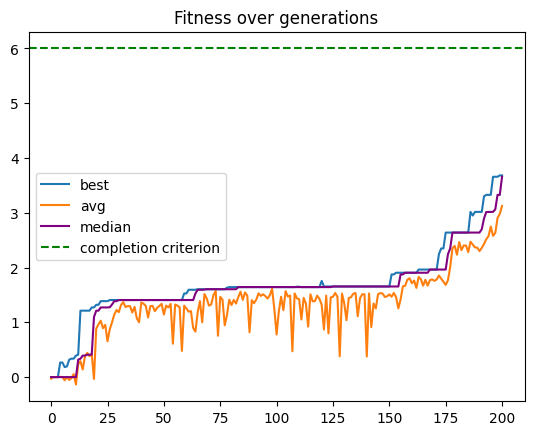

In [28]:
# Plot stats
bests = []
avgs = []
stds = []
medians = []
for stat in log:
    bests.append(stat['best'])
    avgs.append(stat['avg'])
    stds.append(stat['std'])
    medians.append(stat['median'])

utils.plot_data(bests, avgs = avgs, medians = medians, 
                completion_fitness=env.n_task * (environment.REWARD_PICK + environment.REWARD_DROP))

In [25]:
# Read the best individual from file
best = np.load("../results/winners/test15mag2_ga_custom_500_300_200_42_best.npy")

In [26]:
calculate_fitness(best, verbose=True, n_steps=500)


Step 0
Action:  [[-2.         -2.          2.        ]
 [-2.          1.99999559  1.99999997]
 [ 2.         -1.82808702 -2.        ]
 [-2.          2.          2.        ]
 [-2.          1.76713344  1.99998663]
 [ 2.          1.99708203  1.99909647]
 [-2.          2.         -0.7538658 ]
 [-1.9993628  -1.99999999  1.99999975]
 [ 1.68666228  1.99999684 -2.        ]
 [-2.          2.          2.        ]]
. . . . . . . 6 1 . . . . 3 . . . . . .
. 5 . . . . . 9 4 . . . . . . . 8 . . .
. . 7 . . . 0 . . . . . . . . . . 2 . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . O . . . .
. . . . . . . . . . . . . . . . O . . .
. . . . . . . . . . O . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . O O . O . . O . . . . . . . .
. . . . . . . . . . . . . . . . . O . .
. . . . . . . . O . . . . . . O . . . .
. . . . . . . . . . . . O . . . O O . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . O . . . . . . . . 


Step 25
Action:  [[ 2.          2.         -1.96940946]
 [-1.99999992 -2.          2.        ]
 [ 2.         -1.99999915  1.99999605]
 [-2.         -1.98254027  1.99997172]
 [-2.         -2.          1.9599884 ]
 [ 2.          1.96449485  1.99706249]
 [-1.99999669 -2.          2.        ]
 [ 2.         -2.          2.        ]
 [ 2.         -2.          2.        ]
 [ 2.         -2.         -2.        ]]
5 . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . 6 . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . 8 . . . 2
. . . . . . . 1 . . . . . . . . . . . .
. . . . . . . . . . . . . . . O . . . .
. . . . . . . . . . 9 . . . 3 . O . . .
. . . . . . . 7 . . . . . . . . . . . .
. . . . . . . . 0 . . . . 4 . . . . . .
. . . . . O O . . . . O . . . . . . . .
. . . . . . . . . . . . . . . . . O . .
. . . . . . . . O . . . . . . O . . . .
. . . . . . . . . . . . O . . . O O . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . O . . . . . . . .

[119.98740000000001]